In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls "/content/drive/My Drive/automatic-asset-classification"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
ae_res_1_torch  ae_res_3_torch  ae_res_5_torch  data/
ae_res_2_torch  ae_res_4_torch  ae_res_6_torch  models/


# Encoder-Decoder 1

## Data

In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 224
batchsize = 32
tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct(seed=2).label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

## Model

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[0:3]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True)
        )

    def encode(self, x): return self.encoder(x)

    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(decoded, min = 0, max = 1)

## Training and Learner

In [5]:
autoencoder = AutoEncoder();
learn = Learner(data, autoencoder, loss_func=F.mse_loss);
learn = learn.load('ae_res_1')

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


# Encoder-Decoder 2

## Data

In [0]:
train_batches = [(item[0],item[1]) for item in iter(data.train_dl)]
valid_batches = [(item[0],item[1]) for item in iter(data.valid_dl)]

In [0]:
x_train = torch.cat([batch[0] for batch in train_batches])
x_test = torch.cat([batch[0] for batch in valid_batches])
y_train = torch.cat([batch[1] for batch in train_batches])
y_test = torch.cat([batch[1] for batch in valid_batches])

In [0]:
autoencoder.eval()
autoencoder.cuda()

with torch.no_grad():

  encoded_train = autoencoder.encode(x_train); 
  encoded_valid = autoencoder.encode(x_test);

In [77]:
torch.save(autoencoder, 'ae_res_1_new')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
y_train = y_train.cpu().numpy()
y_test = y_test.cpu().numpy()

In [0]:
encoded_train = encoded_train.cpu().numpy()
encoded_valid = encoded_valid.cpu().numpy()

In [0]:
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 2 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
train_ds, valid_ds = ArrayDataset(encoded_train, y_train), ArrayDataset(encoded_valid, y_test)

In [0]:
data2 = DataBunch.create(train_ds, valid_ds, bs=32)

## Model

In [0]:
class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()

        first_layer = torch.load('ae_res_1_new')
        first_layer = nn.Sequential(*[first_layer.decoder])
        for param in first_layer.parameters():
          param.requires_grad = False

        self.full_decode = nn.Sequential(first_layer)
        

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[3:5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[1][i].bn1.parameters():
                param.requires_grad = True
            for param in resnet[1][i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(self.full_decode(decoded), min = 0, max = 1)

## Training

In [83]:
autoencoder2 = AutoEncoder2()
learn2 = Learner(data2, autoencoder2, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [84]:
learn2.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.060764,0.157213,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [85]:
learn2.lr_find()

epoch,train_loss,valid_loss,time
0,0.037527,#na#,00:02
1,0.037544,#na#,00:02
2,0.037263,#na#,00:02
3,0.035536,#na#,00:02
4,0.033810,#na#,00:02
5,0.029615,#na#,00:02
6,0.025180,#na#,00:02
7,0.027177,#na#,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02
Min loss divided by 10: 9.12E-02


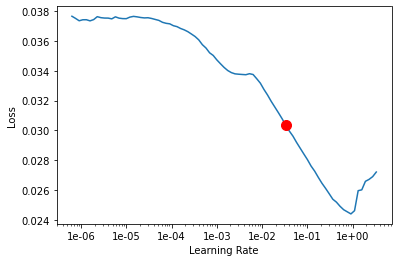

In [86]:
learn2.recorder.plot(suggestion = True)

In [89]:
learn2.fit_one_cycle(100, max_lr = 1e-01)

epoch,train_loss,valid_loss,time
0,0.029835,0.118922,00:02
1,0.022683,0.034326,00:02
2,0.018254,0.017095,00:02
3,0.015491,0.014249,00:02
4,0.013297,0.009487,00:02
5,0.011639,0.007544,00:02
6,0.010446,0.008221,00:02
7,0.009372,0.006166,00:02
8,0.008485,0.007561,00:02
9,0.007902,0.008403,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


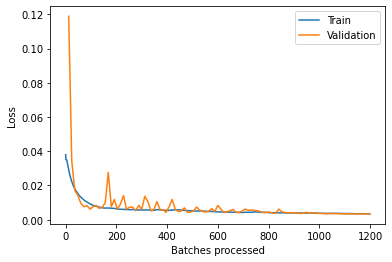

In [90]:
learn2.recorder.plot_losses()

In [91]:
learn2.lr_find()

epoch,train_loss,valid_loss,time
0,0.003432,#na#,00:02
1,0.003442,#na#,00:02
2,0.003493,#na#,00:02
3,0.003443,#na#,00:02
4,0.003433,#na#,00:02
5,0.003485,#na#,00:02
6,0.003824,#na#,00:02
7,0.009117,#na#,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


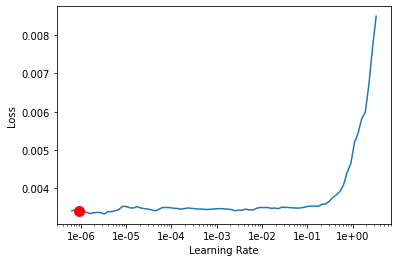

In [92]:
learn2.recorder.plot(suggestion = True)

In [0]:
learn2.unfreeze()

In [94]:
learn2.lr_find()

epoch,train_loss,valid_loss,time
0,0.003537,#na#,00:02
1,0.003476,#na#,00:02
2,0.003459,#na#,00:02
3,0.003505,#na#,00:02
4,0.003696,#na#,00:02
5,0.008526,#na#,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-06
Min loss divided by 10: 5.25E-06


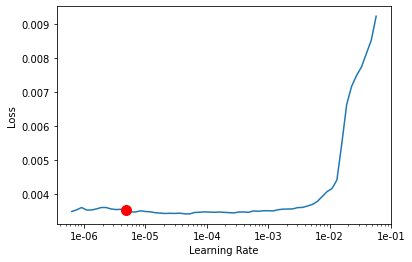

In [95]:
learn2.recorder.plot(suggestion = True)

## Example

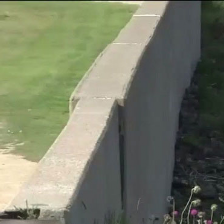

In [96]:
img = data.valid_ds[0][0]
img

In [0]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


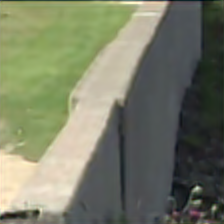

In [103]:
learn.model.eval()
learn2.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model.encode(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())

#Encoder Decoder 3

## Data

In [0]:
autoencoder2.eval()
autoencoder2.cuda()

with torch.no_grad():

  encoded_train = autoencoder2.encode(torch.tensor(encoded_train).cuda()); 
  encoded_valid = autoencoder2.encode(torch.tensor(encoded_valid).cuda());

encoded_train = encoded_train.cpu().numpy()
encoded_valid = encoded_valid.cpu().numpy()

In [108]:
torch.save(autoencoder2, 'ae_res_2_new')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
train_ds, valid_ds = ArrayDataset(encoded_train, y_train), ArrayDataset(encoded_valid, y_test)
data3 = DataBunch.create(train_ds, valid_ds, bs=32)

## Model

In [0]:
class AutoEncoder3(nn.Module):
    def __init__(self):
        super(AutoEncoder3, self).__init__()

        first_layer = torch.load('ae_res_1_new')
        first_layer = nn.Sequential(*[first_layer.decoder])
        for param in first_layer.parameters():
          param.requires_grad = False
        second_layer = torch.load('ae_res_2_new')
        second_layer = nn.Sequential(*[second_layer.decoder])
        for param in second_layer.parameters():
          param.requires_grad = False

        self.full_decode = nn.Sequential(second_layer, first_layer)

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(self.full_decode(decoded), min = 0, max = 1)

## Training

In [122]:
autoencoder3 = AutoEncoder3()
learn3 = Learner(data3, autoencoder3, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [123]:
learn3.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.028194,0.022857,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [124]:
learn3.lr_find()

epoch,train_loss,valid_loss,time
0,0.012663,#na#,00:02
1,0.012681,#na#,00:02
2,0.012629,#na#,00:02
3,0.012510,#na#,00:02
4,0.012104,#na#,00:02
5,0.011155,#na#,00:02
6,0.010273,#na#,00:01
7,0.009585,#na#,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.31E-01


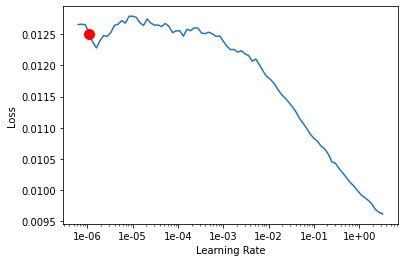

In [125]:
learn3.recorder.plot(suggestion = True)

In [126]:
learn3.fit_one_cycle(100, max_lr = 1e-01)

epoch,train_loss,valid_loss,time
0,0.012643,0.019374,00:02
1,0.011202,0.015406,00:02
2,0.010299,0.012600,00:02
3,0.009795,0.009546,00:02
4,0.009205,0.008567,00:02
5,0.008753,0.007607,00:02
6,0.008417,0.007189,00:02
7,0.008072,0.007292,00:02
8,0.007783,0.006436,00:02
9,0.007462,0.006146,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


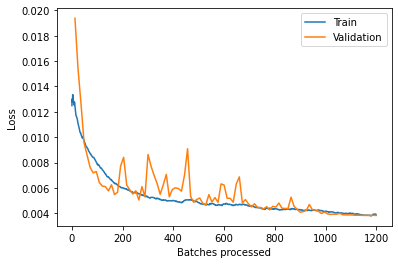

In [127]:
learn3.recorder.plot_losses()

In [0]:
learn3.unfreeze()

In [129]:
learn3.lr_find()

epoch,train_loss,valid_loss,time
0,0.003769,#na#,00:02
1,0.003769,#na#,00:02
2,0.003788,#na#,00:02
3,0.003844,#na#,00:02
4,0.004326,#na#,00:02
5,0.011152,#na#,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.32E-07


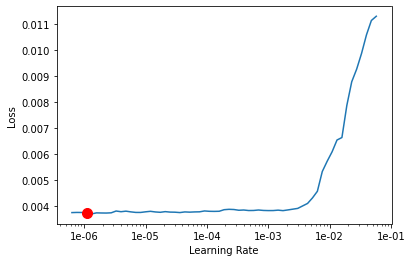

In [130]:
learn3.recorder.plot(suggestion = True)

## Example

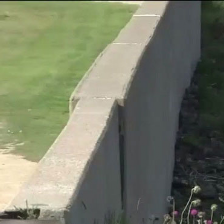

In [131]:
img = data.valid_ds[0][0]
img

In [0]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


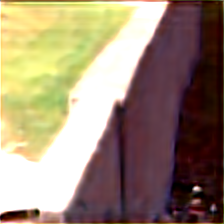

In [133]:
learn.model.eval()
learn2.model.eval()
learn3.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model.encode(pred)
  pred = learn3.model.encode(pred)
  pred = learn3.model.decode(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())

# Encoder Decoder 4

## Data

In [0]:
autoencoder3.eval()
autoencoder3.cuda()

with torch.no_grad():

  encoded_train = autoencoder3.encode(torch.tensor(encoded_train).cuda()); 
  encoded_valid = autoencoder3.encode(torch.tensor(encoded_valid).cuda());

encoded_train = encoded_train.cpu().numpy()
encoded_valid = encoded_valid.cpu().numpy()

In [135]:
torch.save(autoencoder3, 'ae_res_3_new')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
train_ds, valid_ds = ArrayDataset(encoded_train, y_train), ArrayDataset(encoded_valid, y_test)
data4 = DataBunch.create(train_ds, valid_ds, bs=32)

## Model

In [0]:
class AutoEncoder4(nn.Module):
    def __init__(self):
        super(AutoEncoder4, self).__init__()


        first_layer = torch.load('ae_res_1_new')
        first_layer = nn.Sequential(*[first_layer.decoder])
        for param in first_layer.parameters():
          param.requires_grad = False
        second_layer = torch.load('ae_res_2_new')
        second_layer = nn.Sequential(*[second_layer.decoder])
        for param in second_layer.parameters():
          param.requires_grad = False
        third_layer = torch.load('ae_res_3_new')
        third_layer = nn.Sequential(*[third_layer.decoder])
        for param in third_layer.parameters():
          param.requires_grad = False


        self.full_decode = nn.Sequential(third_layer, second_layer, first_layer)


        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[6]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(self.full_decode(decoded), min = 0, max = 1)

## Training

In [148]:
autoencoder4 = AutoEncoder4()
learn4 = Learner(data4, autoencoder4, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [149]:
learn4.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.027227,0.036245,00:03


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [150]:
learn4.lr_find()

epoch,train_loss,valid_loss,time
0,0.014414,#na#,00:02
1,0.014350,#na#,00:02
2,0.014263,#na#,00:02
3,0.014098,#na#,00:02
4,0.013818,#na#,00:02
5,0.013128,#na#,00:02
6,0.012486,#na#,00:02
7,0.011860,#na#,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.31E-01


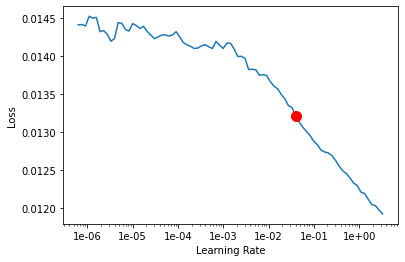

In [151]:
learn4.recorder.plot(suggestion = True)

In [152]:
learn4.fit_one_cycle(100, max_lr = 1e-01)

epoch,train_loss,valid_loss,time
0,0.013373,0.019673,00:03
1,0.012995,0.016061,00:03
2,0.012448,0.013591,00:03
3,0.011992,0.012111,00:03
4,0.011569,0.011562,00:03
5,0.011374,0.010770,00:03
6,0.011124,0.010416,00:03
7,0.010900,0.011861,00:03
8,0.010594,0.010099,00:03
9,0.010284,0.009673,00:03


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


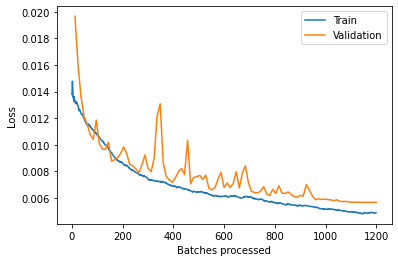

In [153]:
learn4.recorder.plot_losses()

In [0]:
learn4.unfreeze()

In [156]:
learn4.lr_find()

epoch,train_loss,valid_loss,time
0,0.004687,#na#,00:03
1,0.004727,#na#,00:03
2,0.004911,#na#,00:03
3,0.004899,#na#,00:03
4,0.005442,#na#,00:03
5,0.013087,#na#,00:03


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-07


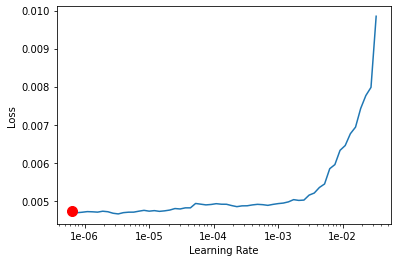

In [158]:
learn4.recorder.plot(suggestion = True)

## Example

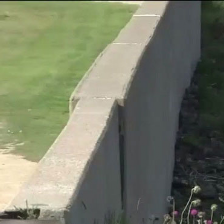

In [159]:
img = data.valid_ds[0][0]
img

In [0]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


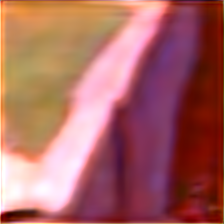

In [161]:
learn.model.eval()
learn2.model.eval()
learn3.model.eval()
learn4.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model.encode(pred)
  pred = learn3.model.encode(pred)
  pred = learn4.model.encode(pred)
  pred = learn4.model.decode(pred)
  pred = learn3.model.decode(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())

# Encoder Decoder 5

## Data

In [0]:
autoencoder4.eval()
autoencoder4.cuda()

with torch.no_grad():

  encoded_train = autoencoder4.encode(torch.tensor(encoded_train).cuda()); 
  encoded_valid = autoencoder4.encode(torch.tensor(encoded_valid).cuda());

encoded_train = encoded_train.cpu().numpy()
encoded_valid = encoded_valid.cpu().numpy()

In [163]:
torch.save(autoencoder4, 'ae_res_4_new')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder4. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
train_ds, valid_ds = ArrayDataset(encoded_train, y_train), ArrayDataset(encoded_valid, y_test)
data5 = DataBunch.create(train_ds, valid_ds, bs=32)

## Model

In [0]:
class AutoEncoder5(nn.Module):
    def __init__(self):
        super(AutoEncoder5, self).__init__()


        first_layer = torch.load('ae_res_1_new')
        first_layer = nn.Sequential(*[first_layer.decoder])
        for param in first_layer.parameters():
          param.requires_grad = False
        second_layer = torch.load('ae_res_2_new')
        second_layer = nn.Sequential(*[second_layer.decoder])
        for param in second_layer.parameters():
          param.requires_grad = False
        third_layer = torch.load('ae_res_3_new')
        third_layer = nn.Sequential(*[third_layer.decoder])
        for param in third_layer.parameters():
          param.requires_grad = False
        fourth_layer = torch.load('ae_res_4_new')
        fourth_layer = nn.Sequential(*[fourth_layer.decoder])
        for param in third_layer.parameters():
          param.requires_grad = False


        self.full_decode = nn.Sequential(fourth_layer, third_layer, second_layer, first_layer)


        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[7]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(self.full_decode(decoded), min = 0, max = 1)

In [174]:
autoencoder5 = AutoEncoder5()
learn5 = Learner(data5, autoencoder5, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [175]:
learn5.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.032261,0.030849,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [176]:
learn5.lr_find()

epoch,train_loss,valid_loss,time
0,0.023087,#na#,00:02
1,0.023100,#na#,00:02
2,0.023088,#na#,00:02
3,0.022857,#na#,00:02
4,0.022229,#na#,00:02
5,0.021548,#na#,00:02
6,0.020567,#na#,00:02
7,0.019412,#na#,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-04
Min loss divided by 10: 3.31E-01


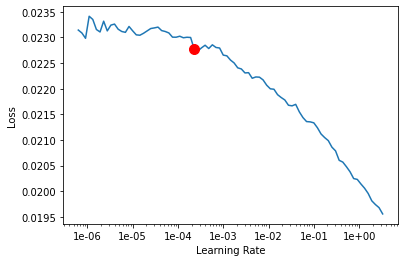

In [177]:
learn5.recorder.plot(suggestion = True)

In [178]:
learn5.fit_one_cycle(100, max_lr = 1e-01)

epoch,train_loss,valid_loss,time
0,0.022718,0.026694,00:02
1,0.021398,0.022636,00:02
2,0.020496,0.020200,00:02
3,0.019724,0.019786,00:02
4,0.019096,0.018836,00:02
5,0.018481,0.018203,00:02
6,0.017988,0.017873,00:02
7,0.017403,0.016536,00:02
8,0.016782,0.016539,00:02
9,0.016283,0.016166,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
learn5.unfreeze()

In [180]:
learn5.lr_find()

epoch,train_loss,valid_loss,time
0,0.005891,#na#,00:03
1,0.005880,#na#,00:02
2,0.005838,#na#,00:02
3,0.005898,#na#,00:03
4,0.006768,#na#,00:03
5,0.015307,#na#,00:03


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-06
Min loss divided by 10: 2.09E-06


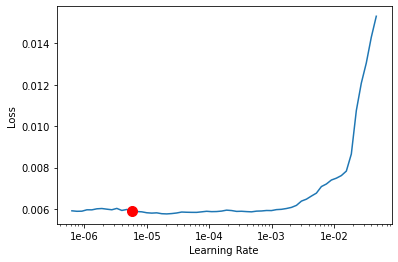

In [181]:
learn5.recorder.plot(suggestion = True)

## Example

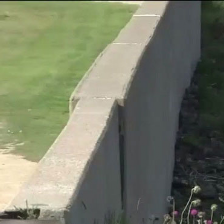

In [182]:
img = data.valid_ds[0][0]
img

In [0]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


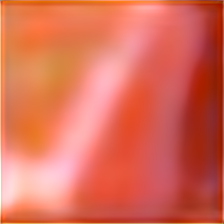

In [184]:
learn.model.eval()
learn2.model.eval()
learn3.model.eval()
learn4.model.eval()
learn5.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model.encode(pred)
  pred = learn3.model.encode(pred)
  pred = learn4.model.encode(pred)
  pred = learn5.model.encode(pred)
  pred = learn5.model.decode(pred)
  pred = learn4.model.decode(pred)
  pred = learn3.model.decode(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())

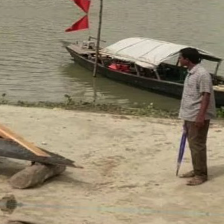

In [185]:
img = data.train_ds[0][0]
img

In [0]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


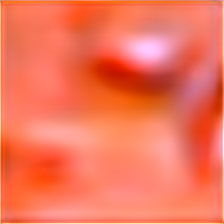

In [187]:
learn.model.eval()
learn2.model.eval()
learn3.model.eval()
learn4.model.eval()
learn5.model.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = learn2.model.encode(pred)
  pred = learn3.model.encode(pred)
  pred = learn4.model.encode(pred)
  pred = learn5.model.encode(pred)
  pred = learn5.model.decode(pred)
  pred = learn4.model.decode(pred)
  pred = learn3.model.decode(pred)
  pred = learn2.model.decode(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())